# Interpolating quantiles comparison between linear interpolation and PchipInterpolator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


from scipy.interpolate import interp1d
import scipy.interpolate as spi
from scipy.interpolate import PchipInterpolator


from scipy.stats import norm
from analysis.tabpfn import *


# Return the interpolated functions only and not the cdf/pdf values themselves

In [46]:
import numpy as np
import scipy.interpolate as spi
from scipy.stats import norm

# --- Function to calculate hybrid CDF and PDF ---
def compute_cdf_pdf_interpolators(quantiles, probabilities, y_min=-30, y_max=30):
    """
    Returns interpolation functions for CDF and PDF using linear, PCHIP, and hybrid methods.

    Parameters:
    - quantiles: Array of quantiles.
    - probabilities: Array of associated probabilities for the quantiles.
    - y_min: Minimum x value for extrapolation.
    - y_max: Maximum x value for extrapolation.

    Returns:
    - cdf_linear(x): Linear interpolation CDF function.
    - cdf_pchip(x): PCHIP interpolation CDF function.
    - hybrid_cdf(x): Hybrid CDF (PCHIP + normal tails).
    - pdf_linear(x): Linear interpolation PDF function.
    - pdf_pchip(x): PCHIP derivative PDF function.
    - pdf_hybrid(x): Hybrid PDF (PCHIP + normal tails).
    """

    # Extend quantile and probability arrays
    full_quantiles = np.concatenate(([y_min], quantiles, [y_max]))
    full_probabilities = np.concatenate(([0], probabilities, [1]))

    # --- Fit Normal Distributions for Tails ---
    def fit_tail_distribution(quantiles, probabilities):
        """Fits a normal distribution to the given quantiles and associated probabilities."""
        z_scores = norm.ppf(probabilities)
        sigma = (quantiles[1] - quantiles[0]) / (z_scores[1] - z_scores[0])
        mu = quantiles[0] - sigma * z_scores[0]
        return mu, sigma

    # Fit left and right tails
    mu_left, sigma_left = fit_tail_distribution(quantiles[:2], probabilities[:2])
    mu_right, sigma_right = fit_tail_distribution(quantiles[-2:], probabilities[-2:])

    # --- Define CDF Interpolators ---
    cdf_linear_interpolator = spi.interp1d(
        full_quantiles, full_probabilities, kind="linear", fill_value=(0, 1), bounds_error=False
    )
    cdf_pchip_interpolator = spi.PchipInterpolator(full_quantiles, full_probabilities, extrapolate=True)

    def cdf_linear(x):
        """Linear interpolation CDF function."""
        return float(np.clip(cdf_linear_interpolator(x), 0, 1))

    def cdf_pchip(x):
        """PCHIP interpolation CDF function."""
        return float(np.clip(cdf_pchip_interpolator(x), 0, 1))

    def hybrid_cdf(x):
        """
        Hybrid CDF:
        - Left normal fit for x < first quantile
        - PCHIP interpolation for middle range
        - Right normal fit for x > last quantile
        """
        if x < quantiles[0]:  # Left tail
            return norm.cdf(x, loc=mu_left, scale=sigma_left)
        elif x > quantiles[-1]:  # Right tail
            return norm.cdf(x, loc=mu_right, scale=sigma_right)
        else:  # Middle range (PCHIP interpolation)
            return float(np.clip(cdf_pchip_interpolator(x), 0, 1))

    # --- Define PDF functions (derivatives of CDFs) ---
    def pdf_linear(x):
        """Approximates PDF using finite differences of the linear CDF."""
        eps = 1e-6  # Small step for numerical differentiation
        return (cdf_linear(x + eps) - cdf_linear(x - eps)) / (2 * eps)

    def pdf_pchip(x):
        """Computes exact PDF by differentiating the PCHIP CDF."""
        return float(cdf_pchip_interpolator.derivative()(x))

    def pdf_hybrid(x):
        """
        Hybrid PDF:
        - Left normal distribution for x < first quantile
        - PCHIP interpolation derivative for middle range
        - Right normal distribution for x > last quantile
        """
        if x < quantiles[0]:  # Left tail
            return norm.pdf(x, loc=mu_left, scale=sigma_left)
        elif x > quantiles[-1]:  # Right tail
            return norm.pdf(x, loc=mu_right, scale=sigma_right)
        else:  # Middle range (PCHIP interpolation)
            return float(cdf_pchip_interpolator.derivative()(x))

    return cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_pchip, pdf_hybrid


In [3]:
quantiles = np.array([-2, -1, 0, 1, 2])
probabilities = np.array([0.1, 0.25, 0.5, 0.75, 0.9])

cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(quantiles, probabilities, -3, 3)

# Test the functions
x_values = np.linspace(-3, 3, 10)

print("Linear CDF:", cdf_linear(x_values))
print("PCHIP CDF:", cdf_pchip(x_values))
print("Hybrid CDF:", hybrid_cdf(x_values))

print("Linear PDF:", pdf_linear(x_values))
print("PCHIP PDF:", pdf_pchip(x_values))
print("Hybrid PDF:", pdf_hybrid(x_values))

Linear CDF: [0.         0.06666667 0.15       0.25       0.41666667 0.58333333
 0.75       0.85       0.93333333 1.        ]
PCHIP CDF: [0.         0.06185185 0.14277778 0.25       0.41203704 0.58796296
 0.75       0.85722222 0.93814815 1.        ]
Hybrid CDF: [0.02947183 0.068917   0.14277778 0.25       0.41203704 0.58796296
 0.75       0.85722222 0.931083   0.97052817]
Linear PDF: [0.1    0.1125 0.1375 0.2    0.25   0.25   0.2    0.1375 0.1125 0.1   ]
PCHIP PDF: [0.075      0.10833333 0.1375     0.1875     0.27083333 0.27083333
 0.1875     0.1375     0.10833333 0.075     ]
Hybrid PDF: [0.04070137 0.080536   0.1375     0.1875     0.27083333 0.27083333
 0.1875     0.1375     0.080536   0.04070137]


# plot the interpolated function

In [4]:
def plot_cdf_pdf(quantiles, probabilities, y_min, y_max, log_scale=True):
    
    """Plots the CDF and PDF for linear, pchip, and hybrid interpolation methods."""
    
    x_values = np.linspace(y_min - 1, y_max + 1, 200)

    cdf_linear, cdf_pchip, cdf_hybrid, pdf_linear, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(quantiles, probabilities, -3, 3)

    # Get CDF and PDF values
    cdf_values_linear = cdf_linear(x_values)
    cdf_values_pchip = cdf_pchip(x_values)
    cdf_values_hybrid = cdf_hybrid(x_values)
    
    pdf_values_linear = pdf_linear(x_values)
    pdf_values_pchip = pdf_pchip(x_values)
    pdf_values_hybrid = pdf_hybrid(x_values)
    

    # --- Plot CDFs ---
    plt.figure(figsize=(11, 6))
    plt.plot(x_values, cdf_values_linear, label="Linear Interpolation CDF", color='b', linestyle='--', linewidth=1)
    plt.plot(x_values, cdf_values_pchip, label="PCHIP Interpolation CDF", color='g', linewidth=1)
    plt.plot(x_values, cdf_values_hybrid, label="Hybrid CDF (Interpolated + Normal Tails)", color='m', linewidth=1)
    plt.scatter(quantiles, probabilities, color='r', marker='o', label="Quantiles")
    plt.xlabel("Value")
    plt.ylabel("Cumulative Probability")
    plt.title("Comparison of CDFs: Linear, PCHIP, and Hybrid")

    plt.legend()
    plt.grid(True)
    plt.xlim(x_values[0], x_values[-1])
    plt.show()

    # --- Plot PDFs (Derivatives) ---
    plt.figure(figsize=(11, 6))

    plt.plot(x_values, pdf_values_linear, label="Linear Interpolation PDF", color='b', linestyle='--', linewidth=1)
    plt.plot(x_values, pdf_values_pchip, label="PCHIP Interpolation PDF", color='g', linewidth=1)
    plt.plot(x_values, pdf_values_hybrid, label="Hybrid PDF", color='m', linewidth=1)

    
    #plt.scatter(quantiles, pdf_at_quantiles_linear, color='b', marker='o', s=50, label="Linear PDF at Quantiles", facecolors='none')
    #plt.scatter(quantiles, pdf_at_quantiles_pchip, color='g', marker='v', s=50, label="PCHIP PDF at Quantiles")
    #plt.scatter(quantiles, pdf_at_quantiles_hybrid, color='m', marker='x', s=30, label="Hybrid PDF at Quantiles")

    
    # PDF evaluated at quantiles
    pdf_at_quantiles_linear = pdf_linear(quantiles)
    pdf_at_quantiles_pchip = pdf_pchip(quantiles)
    pdf_at_quantiles_hybrid = pdf_hybrid(quantiles)

    plt.scatter(quantiles, pdf_at_quantiles_linear, color='b', marker='o', s=15, label="Linear PDF at Quantiles") #facecolors='none')
    plt.scatter(quantiles, pdf_at_quantiles_pchip, color='g', marker='v', s=15, label="PCHIP PDF at Quantiles")
    plt.scatter(quantiles, pdf_at_quantiles_hybrid, color='m', marker='x', s=15, label="Hybrid PDF at Quantiles")

    plt.xlabel("Value")
    plt.title("Comparison of PDFs: Linear, PCHIP, and Hybrid")

    plt.legend()
    plt.grid(True)
    plt.xlim(x_values[0], x_values[-1])

    if log_scale:
        plt.yscale("log")
        plt.ylim(1e-3, 1)
        plt.ylabel("Probability Density (log scale)")

    else:
        plt.ylabel("Probability Density")
    
    plt.show()

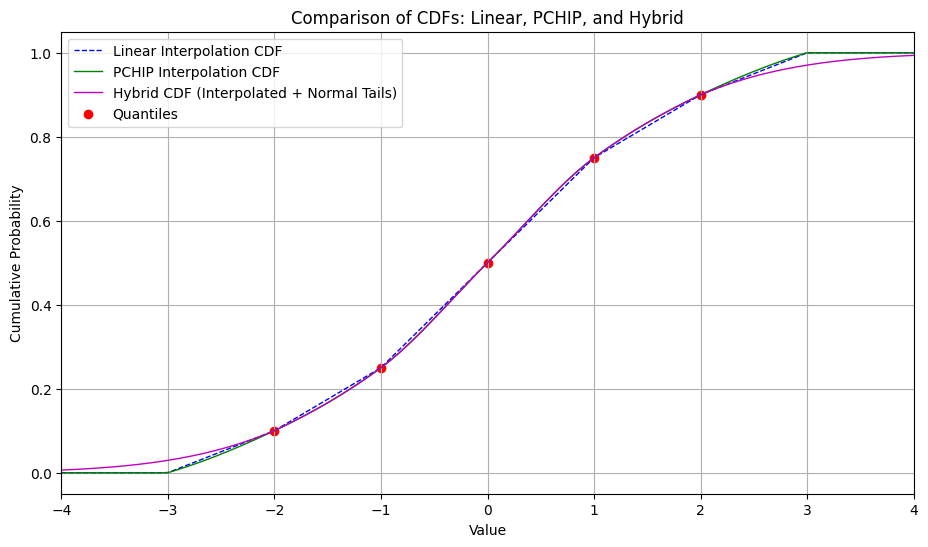

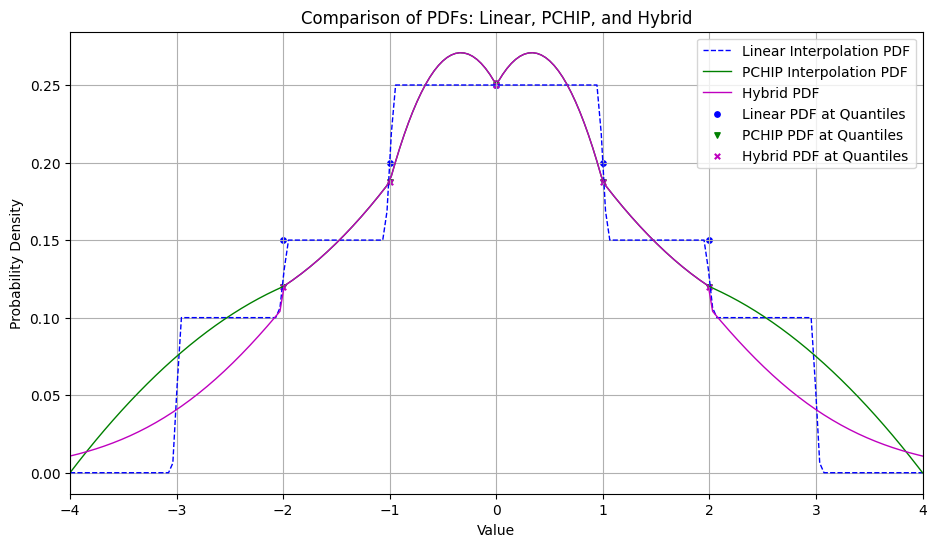

In [5]:
quantiles = np.array([-2, -1, 0, 1, 2])
probabilities = np.array([0.1, 0.25, 0.5, 0.75, 0.9])

plot_cdf_pdf(quantiles, probabilities, -3, 3, log_scale=False)

In [6]:
quantiles = np.array([-2, -1, 0, 1, 2])
probabilities = np.array([0.1, 0.25, 0.5, 0.75, 0.9])

cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(quantiles, probabilities, -3, 3)

# Test the functions
x_values = np.linspace(-3, 3, 10)

print("Linear CDF:", cdf_linear(x_values))
print("PCHIP CDF:", cdf_pchip(x_values))
print("Hybrid CDF:", hybrid_cdf(x_values))

print("Linear PDF:", pdf_linear(x_values))
print("PCHIP PDF:", pdf_pchip(x_values))
print("Hybrid PDF:", pdf_hybrid(x_values))

Linear CDF: [0.         0.06666667 0.15       0.25       0.41666667 0.58333333
 0.75       0.85       0.93333333 1.        ]
PCHIP CDF: [0.         0.06185185 0.14277778 0.25       0.41203704 0.58796296
 0.75       0.85722222 0.93814815 1.        ]
Hybrid CDF: [0.02947183 0.068917   0.14277778 0.25       0.41203704 0.58796296
 0.75       0.85722222 0.931083   0.97052817]
Linear PDF: [0.1    0.1125 0.1375 0.2    0.25   0.25   0.2    0.1375 0.1125 0.1   ]
PCHIP PDF: [0.075      0.10833333 0.1375     0.1875     0.27083333 0.27083333
 0.1875     0.1375     0.10833333 0.075     ]
Hybrid PDF: [0.04070137 0.080536   0.1375     0.1875     0.27083333 0.27083333
 0.1875     0.1375     0.080536   0.04070137]


In [ ]:
def negative_log_likelihood(y_true, pdf_function):
    """
    Computes the total negative log-likelihood for an array of true values.
    
    Parameters:
    - y_true: Array of observed true values.
    - pdf_function: A function that computes the PDF.
    
    Returns:
    - The total negative log-likelihood.
    """
    pdf_values = pdf_function(y_true)  # Compute PDF for each y in y_true
    
    # Avoid log(0) by setting a small threshold
    #epsilon = 1e-10
    #pdf_values = np.maximum(pdf_values, epsilon)

    return np.log(pdf_values)


In [38]:
quantiles = np.array([-2, -1, 0, 1, 2])
probabilities = np.array([0.1, 0.25, 0.5, 0.75, 0.9])
#y_true = np.array([0.5, -1.2, 1.8, 0.0, 2.5])
y_true = np.array(0.5)


cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(quantiles, probabilities, -3, 3)

nll_linear = negative_log_likelihood(y_true, pdf_linear)
nll_pchip = negative_log_likelihood(y_true, pdf_pchip)
nll_hybrid = negative_log_likelihood(y_true, pdf_hybrid)

print("=== Negative Log-Likelihood (NLL) Comparison ===")

nll_linear
#print(f"Linear PDF NLL:  {nll_linear:.6f}")
#print(f"PCHIP PDF NLL:   {nll_pchip:.6f}")
#print(f"Hybrid PDF NLL:  {nll_hybrid:.6f}")

=== Negative Log-Likelihood (NLL) Comparison ===


array([], dtype=float64)

In [45]:
pdf_linear(np.array([-2]))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
import numpy as np
import scipy.interpolate as spi
from scipy.stats import norm

def crps(y_true, cdf_forecast, y_min, y_max, num_points=1000):
    """
    Computes the Continuous Ranked Probability Score (CRPS) for a given true value and forecast CDF,
    over the range defined by y_min and y_max.
    
    Parameters:
    - y_true: The observed value (a single value).
    - cdf_forecast: A CDF function (e.g., cdf_linear, cdf_pchip, hybrid_cdf).
    - y_min: Minimum value for the CDF range.
    - y_max: Maximum value for the CDF range.
    - num_points: Number of points used to evaluate the CDF.
    
    Returns:
    - CRPS value for the true value.
    """
    # Generate a range of x values between y_min and y_max
    x_range = np.linspace(y_min, y_max, num_points)
    
    # CDF of the observed value (Indicator function)
    def cdf_observed(x, y_true):
        return np.where(x >= y_true, 1, 0)  # 1 when x >= y_true, otherwise 0

    # Compute the difference between the CDFs
    diff = cdf_forecast(x_range) - cdf_observed(x_range, y_true)
    
    # Square the difference
    squared_diff = diff ** 2
    
    # Integrate over the range (numerically, using the mean of squared differences)
    crps_value = np.mean(squared_diff)
    
    return crps_value


## 1. Define an array of true observed values:
- `y_true = np.array([0.5, -1.2, 1.8, 0.0, 2.5])`

## 2. Call `compute_cdf_pdf_interpolators`
- Generates 3 CDF and 3 PDF functions based on the given quantiles and probabilities:
    - `quantiles = np.array([-2, -1, 0, 1, 2])`
    - `probabilities = np.array([0.1, 0.25, 0.5, 0.75, 0.9])`

### 2.1 Extend the Quantiles
- Extends the given quantiles to include the minimum (`y_min=-3`) and maximum (`y_max=3`)
- `full_quantiles = [-3, -2, -1, 0, 1, 2, 3]`
- `full_probabilities = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]`

### 2.2 Define Interpolated CDF and PDF Functions
#### CDF Functions:
- **`cdf_linear`**: Linear interpolation of `full_quantiles` and `full_probabilities`.
- **`cdf_pchip`**: Piecewise cubic Hermite interpolation for smooth interpolation.
- **`hybrid_cdf`**: Uses:
    - Normal CDF in tails
    - PCHIP interpolation in the middle

#### PDF Functions:
- **`pdf_linear`**: Numerical gradient of `cdf_linear`
- **`pdf_pchip`**: Derivative of `cdf_pchip`
- **`pdf_hybrid`**: Uses `pdf_pchip` in the middle, normal PDF for tails

#### 2.2.1 Fit Normal Distributions for Tails
- Estimates PDF values outside the range `[-2,2]` by fitting normal distributions.

## 3. Call `negative_log_likelihood(y_true, pdf_hybrid)`

### 3.1 Compute PDF Values
- `pdf_hybrid(y_true)` is called, which:
    - Uses **normal PDF** for values **outside** `[-2, 2]`.
    - Uses **PCHIP-derived PDF** for values **inside** `[-2, 2]`.

- For `y_true = [0.5, -1.2, 1.8, 0.0, 2.5]`:
    - `0.5` is **inside** `[-2, 2]` → Uses `pdf_pchip`
    - `-1.2` is **inside** `[-2, 2]` → Uses `pdf_pchip`
    - `1.8` is **inside** `[-2, 2]` → Uses `pdf_pchip`
    - `0.0` is **inside** `[-2, 2]` → Uses `pdf_pchip`
    - `2.5` is **outside** `[-2, 2]` → Uses **right tail normal PDF**
